In [1]:
import numpy as np
from scipy.linalg import eigvals
from scipy.integrate import solve_ivp
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
MU = 3.986e+14                                 # [m^3 / s^2] standard gravitational parameter of the Earth
MU_0 = 1.257e-6                                # [N / A^2] vacuum permeability
MU_e = 7.94e+22                                # [A * m^2] magnetic dipole moment of the Earth

R_e = 6371e+3                                  # [m] radius of the Earth
altitude = 800e+3                              # [m] altitude of the orbit
incl = np.pi / 3.                              # [rad] inclination of the orbit

R_orb = R_e + altitude                         # [m] radius of the orbit
omega_0 = np.sqrt(MU / R_orb**3.)              # [rad / s] angular velocity on the orbit

J = np.array([0.009, 0.011, 0.014])                  # [kg * m^2] inertia tensor for satellite
B_0 = MU_e * MU_0 / (4 * np.pi * R_orb**3.)    # [T] magnitude of the magnetic field  on the orbit

def B_orb(u, i = incl):
    
    """
    B(latitude, inclination) -- magnetic field on the orbit
    :param u: latitude in degrees
    :param i: inclination in degrees (60 by default)
    :returns: 3-axis magnetic field
    """
    
    return np.array([-2.*np.sin(u)*np.sin(i), np.cos(u)*np.sin(i), np.cos(i)])

In [3]:
def Jacobian(u, Kw, Ka, B_magn, omega_orb, J_sat):
    
    B = B_orb(u)
    B01 = B[0] * B[1]
    B02 = B[0] * B[2]
    B12 = B[1] * B[2]
    B01sqr = B[0]**2. + B[1]**2.
    B02sqr = B[0]**2. + B[2]**2.
    B12sqr = B[1]**2. + B[2]**2.
    
    kw = Kw * B_magn**2. / omega_orb / J_sat
    ka = 2. * Ka * B_magn**2. / J_sat
    
    return np.array([[-kw[0] * B12sqr,
                     kw[0] * B01 + omega_orb * ((J_sat[0] + J_sat[1] - J_sat[2]) / J_sat[0]),
                     kw[0] * B02,
                     -ka[0] * B12sqr + omega_orb**2 * ((J_sat[1] - J_sat[2]) / J_sat[0]),
                     ka[0] * B02,
                     ka[0] * B01],
                    [kw[1] * B01 + omega_orb * ((-J_sat[0] - J_sat[1] + J_sat[2]) / J_sat[1]),
                     -kw[1] * B02sqr,
                     kw[1] * B12,
                     ka[1] * B01,
                     ka[1] * B12,
                     -ka[1] * B02sqr + 4. * omega_orb**2 * ((J_sat[0] - J_sat[2]) / J_sat[1])],
                    [kw[2] * B02,
                     kw[2] * B12,
                     -kw[2] * B01sqr,
                     ka[2] * B02,
                     -ka[2] * B01sqr + 3. * omega_orb**2 * ((J_sat[0] - J_sat[1]) / J_sat[2]),
                     ka[2] * B12],
                    [1., 0., 0., 0., 0., 0.],
                    [0., 0., 1., 0., 0., 0.],
                    [0., 1., 0., 0., 0., 0.]]) / omega_orb

def monodromy_array(Kw, Ka, B_magn, omega_orb, J_sat):
    
    def fun(u, x):
        
        return Jacobian(u, Kw, Ka, B_magn, omega_orb, J_sat).dot(x.reshape((6,6))).flatten()
    
    flat_mdrm = solve_ivp(fun, (0, 2 * np.pi), np.identity(6).flatten()).y[:,-1]
    return flat_mdrm.reshape((6,6))

def coef_distribution(K, **kw):
    
    Kw, Ka = K
    
    return np.max(np.real(np.log(eigvals(monodromy_array(Kw, Ka, kw['B_magn'], kw['omega_orb'], kw['J_sat'])))))

In [10]:
print(coef_distribution((50, 75), B_magn=B_0, omega_orb=omega_0, J_sat=J))

2.7042080353402396


In [4]:
def plot_coefficients(N1, N2, dN, n, B_0, omega_0, J):
    
    x = np.linspace(N1, N1+dN, n)
    X = np.repeat([x], n, axis=0)
    y = np.linspace(N2+dN, N2, n)
    Y = np.transpose(np.repeat([y], n, axis=0))

    f_points = np.dstack((X, Y))

    Z = np.apply_along_axis(coef_distribution, -1, f_points, B_magn=B_0, omega_orb=omega_0, J_sat=J)
    i,j = np.where(Z == np.min(Z))

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    im = ax.imshow(Z, interpolation='spline36', cmap=cm.coolwarm, extent=[N1, N1+dN, N2, N2+dN])
    ax.set_title('Coefficients: $K_w = ${0}, $K_a = ${1}'.format(int(f_points[i,j,0]), int(f_points[i,j,1])))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

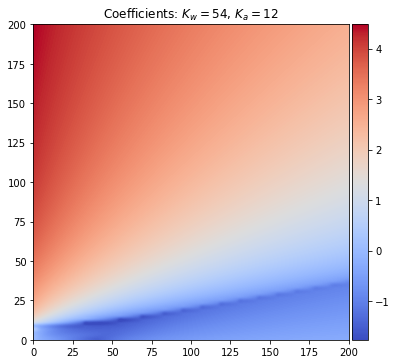

In [5]:
N1 = 0
N2 = 0
dN = 200
n = 100

plot_coefficients(N1, N2, dN, n, B_0, omega_0, J)

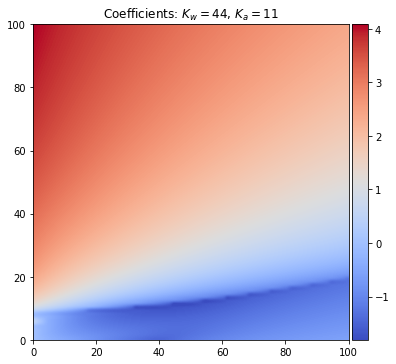

In [6]:
N1 = 0
N2 = 0
dN = 100
n = 100

plot_coefficients(N1, N2, dN, n, B_0, omega_0, J)

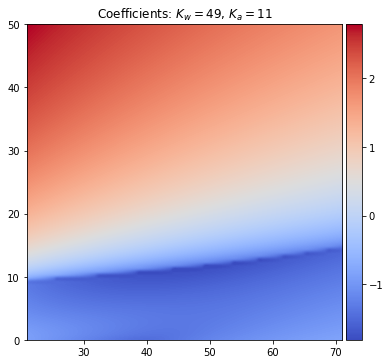

In [7]:
N1 = 21
N2 = 0
dN = 50
n = 100

plot_coefficients(N1, N2, dN, n, B_0, omega_0, J)